In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal


from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


import string
alphabet = list(string.ascii_lowercase)
          

## Data

Data for this is from https://gmd.copernicus.org/articles/11/1133/2018/ CDRMIP data, where pi-CO2pulse is the 100GtC pulse and piControl is the control

In [2]:
G_ds = xr.open_dataset('Outputs/G_pulse_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']

G_ds = xr.concat([G_ds, -G_cdr_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

G_ds = G_ds.rename({'year':'s'})

In [3]:
G_climatology_ds = xr.open_dataset('Outputs/G_ds_climatology.nc4')['__xarray_dataarray_variable__']
G_cdr_climatology_ds = xr.open_dataset('Outputs/G_cdr_ds_climatology.nc4')['__xarray_dataarray_variable__']

G_climatology_ds = xr.concat([G_climatology_ds, -G_cdr_climatology_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

G_climatology_ds = G_climatology_ds.rename({'year':'s'})

In [4]:
Gpoly_clim = G_climatology_ds.polyfit('s', 4)
Gpolyfit_clim= xr.polyval(G_climatology_ds.s, Gpoly_clim)['polyfit_coefficients']

In [5]:
G_poly_ds = xr.open_dataset('Outputs/G_poly_ds.nc4')
G_cdr_poly_ds = xr.open_dataset('Outputs/G_poly_cdr_ds.nc4')

G_poly_ds = xr.concat([G_poly_ds, -G_cdr_poly_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

G_poly_ds = G_poly_ds.rename({'year':'s'})

In [6]:
A = utils.A

In [7]:
model_color = utils.model_color

In [8]:
type_color = utils.type_color

In [9]:
model_weights = utils.model_weights
onepct_model_weights = utils.fourx_model_weights#onepct_model_weights

In [10]:
ds_dif = xr.open_dataset('Outputs/hist_co2_only_ds_dif.nc4')#xr.open_dataset('Outputs/ds_dif.nc4')

# Compare 1pct scenario across the rolling means

In [12]:
emis_profile = xr.open_dataset('Outputs/hist_co2_only_emis_profile_full.nc4')#xr.open_dataset(f'Outputs/1pct_emis_profile_full.nc4')
emis_profile = emis_profile.rename({'__xarray_dataarray_variable__':'emis'})

# Plots of the Convolution difference for rolling means



## Convolution

### Normal G Convolution

In [14]:
%%time
GF = G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'model')

conv_1pct_mean = {}
for m1 in ['CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1', 'CANESM5_r4p1',
       'CANESM5_r5p1', 'CANESM5_r6p1', 'CANESM5_r7p1', 'CANESM5_r8p1',
       'CANESM5_r9p1']:
    conv_1pct_mean[m1] = {}
    for t in ['pulse','cdr']:
        conv_1pct_mean[m1][t] = signal.convolve( np.array(GF.sel( pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
        conv_1pct_mean[m1][t] = utils.np_to_xr_mean(conv_1pct_mean[m1][t], GF.sel(pulse_type = t), emis_profile.sel(model = m1))

conv_1pct_mean_rolling = {}
for roll_amt in [5,10,30]:
    conv_1pct_mean_rolling[roll_amt] = {}
    for m1 in ['CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1', 'CANESM5_r4p1',
       'CANESM5_r5p1', 'CANESM5_r6p1', 'CANESM5_r7p1', 'CANESM5_r8p1',
       'CANESM5_r9p1']:
        conv_1pct_mean_rolling[roll_amt][m1] = {}
        for t in ['pulse','cdr']:

            conv_1pct_mean_rolling[roll_amt][m1][t] = signal.convolve(np.array(GF.sel(pulse_type = t).rolling(s = roll_amt, center = False, min_periods = 1).mean('s').dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
            conv_1pct_mean_rolling[roll_amt][m1][t] = utils.np_to_xr_mean(conv_1pct_mean_rolling[roll_amt][m1][t], GF.sel(pulse_type = t).rolling(s = roll_amt, center = False, min_periods = 1).mean('s'), emis_profile.sel(model = m1))


CPU times: user 2.42 s, sys: 508 ms, total: 2.93 s
Wall time: 2.94 s


In [15]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct_mean.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct_mean[m][t] for t in conv_1pct_mean[m].keys()], pd.Index([t for t in conv_1pct_mean[m].keys()], name='pulse_type'), coords='minimal')
conv_1pct_mean_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')

#convert to dataset

conv_1pct_rolling_dict = {}
conv_1pct_mean_rolling_ds = {}
for roll_amt in [5,10,30]:
    conv_1pct_rolling_dict[roll_amt] = {}
    for m in conv_1pct_mean_rolling[roll_amt].keys():

        conv_1pct_rolling_dict[roll_amt][m] = xr.concat([conv_1pct_mean_rolling[roll_amt][m][t] for t in conv_1pct_mean_rolling[roll_amt][m].keys()], pd.Index([t for t in conv_1pct_mean_rolling[roll_amt][m].keys()], name='pulse_type'), coords='minimal')
    conv_1pct_mean_rolling_ds[roll_amt] = xr.concat([conv_1pct_rolling_dict[roll_amt][m] for m in conv_1pct_rolling_dict[roll_amt].keys()], pd.Index([m for m in conv_1pct_rolling_dict[roll_amt].keys()], name='model'), coords='minimal')



### Climatological G Convolution

In [16]:
%%time
GF = G_climatology_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'model')

conv_climatology_1pct_mean = {}
for m1 in ['CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1', 'CANESM5_r4p1',
       'CANESM5_r5p1', 'CANESM5_r6p1', 'CANESM5_r7p1', 'CANESM5_r8p1',
       'CANESM5_r9p1']:
    conv_climatology_1pct_mean[m1] = {}
    for t in ['pulse','cdr']:

        conv_climatology_1pct_mean[m1][t] = signal.convolve( np.array(GF.sel( pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
        conv_climatology_1pct_mean[m1][t] = utils.np_to_xr_mean(conv_climatology_1pct_mean[m1][t], GF.sel( pulse_type = t), emis_profile.sel(model = m1))

conv_climatology_1pct_mean_rolling = {}
for roll_amt in [5,10,30]:
    conv_climatology_1pct_mean_rolling[roll_amt] = {}
    for m1 in ['CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1', 'CANESM5_r4p1',
       'CANESM5_r5p1', 'CANESM5_r6p1', 'CANESM5_r7p1', 'CANESM5_r8p1',
       'CANESM5_r9p1']:
        conv_climatology_1pct_mean_rolling[roll_amt][m1] = {}
        for t in ['pulse','cdr']:

            conv_climatology_1pct_mean_rolling[roll_amt][m1][t] = signal.convolve(np.array(GF.sel( pulse_type = t).rolling(s = roll_amt, center = False, min_periods = 1).mean('s').dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
            conv_climatology_1pct_mean_rolling[roll_amt][m1][t] = utils.np_to_xr_mean(conv_climatology_1pct_mean_rolling[roll_amt][m1][t], GF.sel( pulse_type = t).rolling(s = roll_amt, center = False, min_periods = 1).mean('s'), emis_profile.sel(model = m1))


CPU times: user 2.37 s, sys: 546 ms, total: 2.92 s
Wall time: 2.93 s


In [17]:
#convert to dataset

conv_climatology_1pct_dict = {}
for m in conv_1pct_mean.keys():
    conv_climatology_1pct_dict[m] = xr.concat([conv_climatology_1pct_mean[m][t] for t in conv_climatology_1pct_mean[m].keys()], pd.Index([t for t in conv_climatology_1pct_mean[m].keys()], name='pulse_type'), coords='minimal')
conv_climatology_1pct_mean_ds = xr.concat([conv_climatology_1pct_dict[m] for m in conv_climatology_1pct_dict.keys()], pd.Index([m for m in conv_climatology_1pct_dict.keys()], name='model'), coords='minimal')

#convert to dataset

conv_climatology_1pct_rolling_dict = {}
conv_climatology_1pct_mean_rolling_ds = {}
for roll_amt in [5,10,30]:
    conv_climatology_1pct_rolling_dict[roll_amt] = {}
    for m in conv_climatology_1pct_mean_rolling[roll_amt].keys():

        conv_climatology_1pct_rolling_dict[roll_amt][m] = xr.concat([conv_climatology_1pct_mean_rolling[roll_amt][m][t] for t in conv_climatology_1pct_mean_rolling[roll_amt][m].keys()], pd.Index([t for t in conv_climatology_1pct_mean_rolling[roll_amt][m].keys()], name='pulse_type'), coords='minimal')
    conv_climatology_1pct_mean_rolling_ds[roll_amt] = xr.concat([conv_climatology_1pct_rolling_dict[roll_amt][m] for m in conv_climatology_1pct_rolling_dict[roll_amt].keys()], pd.Index([m for m in conv_climatology_1pct_rolling_dict[roll_amt].keys()], name='model'), coords='minimal')



### Polyfit Convolution

In [18]:
%%time
GF = G_poly_ds.weighted(A).mean(dim = ['lat','lon'])['tas_polyfit_coefficients'].mean(dim = 'model')

conv_poly_1pct_mean = {}
for p in ['normal_base_pulse', 'polyfit_base_pulse']:
    conv_poly_1pct_mean[p] = {}
    for m1 in ['CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1', 'CANESM5_r4p1',
       'CANESM5_r5p1', 'CANESM5_r6p1', 'CANESM5_r7p1', 'CANESM5_r8p1',
       'CANESM5_r9p1']:
        conv_poly_1pct_mean[p][m1] = {}
        for t in ['pulse','cdr']:

            conv_poly_1pct_mean[p][m1][t] = signal.convolve( np.array(GF.sel( pulse_type = t, polyfit_type = p).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
            conv_poly_1pct_mean[p][m1][t] = utils.np_to_xr_mean(conv_poly_1pct_mean[p][m1][t], GF.sel( pulse_type = t, polyfit_type = p), emis_profile.sel(model = m1))

CPU times: user 3.61 s, sys: 1.01 s, total: 4.62 s
Wall time: 4.64 s


In [19]:
conv_poly_1pct_dict = {}
conv_poly_1pct_mean_ds = {}
for polyfit in ['normal_base_pulse', 'polyfit_base_pulse']:
    
    conv_poly_1pct_dict[polyfit] = {}
    for m in conv_poly_1pct_mean[polyfit].keys():
        
        conv_poly_1pct_dict[polyfit][m] = xr.concat([conv_poly_1pct_mean[polyfit][m][t] for t in conv_poly_1pct_mean[polyfit][m].keys()], 
                                                     pd.Index([t for t in conv_poly_1pct_mean[polyfit][m].keys()], name='pulse_type'), coords='minimal')
        
    
    conv_poly_1pct_mean_ds[polyfit] = xr.concat([conv_poly_1pct_dict[polyfit][m] for m in conv_poly_1pct_dict[polyfit].keys()], 
                                           pd.Index([m for m in conv_poly_1pct_dict[polyfit].keys()], name='model'), coords='minimal')
conv_poly_1pct_mean_ds = xr.concat([conv_poly_1pct_mean_ds[polyfit] for m in conv_poly_1pct_dict.keys()], 
                              pd.Index([m for m in conv_poly_1pct_dict.keys()], name='polyfit'), coords='minimal')


## Plot

Text(0, 0.5, '$\\Delta$T ($\\degree$C)')

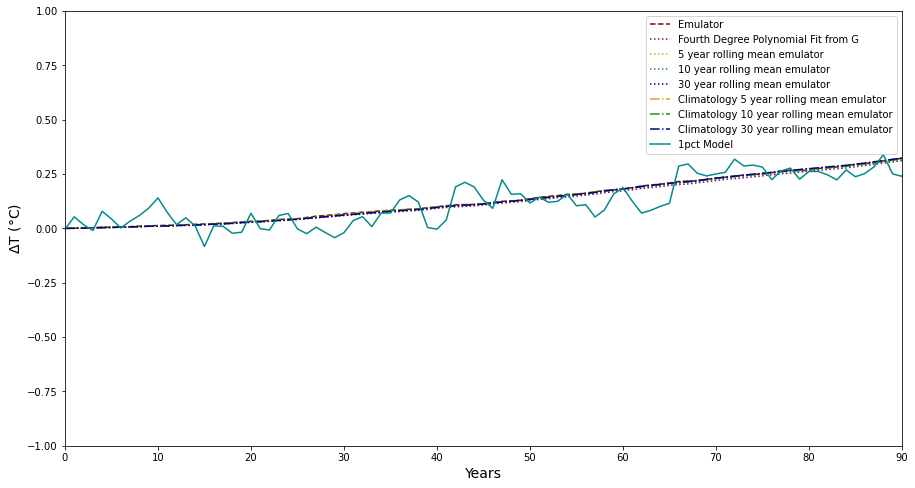

In [23]:
fig, ax = plt.subplots(figsize = (15,8))

plt.plot(conv_1pct_mean_ds.mean(dim = ['model', 'pulse_type']), label = f'Emulator', color = type_color['emulator_1pct'], linestyle = '--')

p_fit_name_dict = {'normal_base_pulse':'Fourth Degree Polynomial Fit from G', 'polyfit_base_pulse':'Fourth Degree Polynomial Fit from base/pulse'}
p_fit_linestyle_dict = {'normal_base_pulse':':', 'polyfit_base_pulse':'-.'}
for polyfit in ['normal_base_pulse']:
    plt.plot(conv_poly_1pct_mean_ds.sel(polyfit = polyfit).mean(dim = ['model', 'pulse_type']), label = p_fit_name_dict[polyfit], 
             color = 'purple', linestyle = p_fit_linestyle_dict[polyfit])



for roll_amt in [5,10,30]:
    plt.plot(conv_1pct_mean_rolling_ds[roll_amt].mean(dim = ['model', 'pulse_type']), label = f'{roll_amt} year rolling mean emulator', 
             color = roll_amt_color_dict[roll_amt], linestyle = ':')

for roll_amt in [5,10,30]:
    plt.plot(conv_climatology_1pct_mean_rolling_ds[roll_amt].mean(dim = ['model', 'pulse_type']), label = f'Climatology {roll_amt} year rolling mean emulator', 
             color = roll_amt_color_dict[roll_amt], linestyle = '-.')



plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         label = '1pct Model', color = type_color['model_1pct'])
plt.legend()
plt.xlim(0,90)
plt.ylim(-1,1)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
#plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


Text(0, 0.5, '$\\Delta$T ($\\degree$C)')

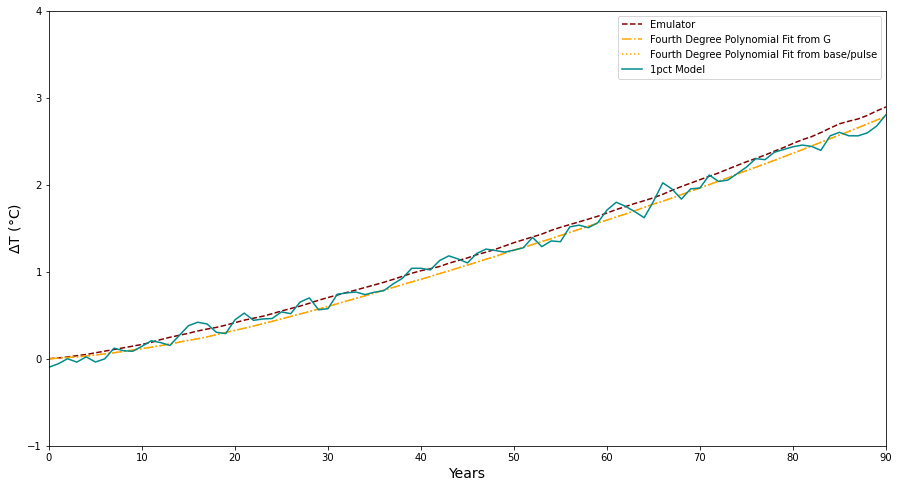

In [95]:
fig, ax = plt.subplots(figsize = (15,8))

plt.plot(conv_1pct_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']), label = f'Emulator', color = type_color['emulator_1pct'], linestyle = '--')

p_fit_name_dict = {'normal_base_pulse':'Fourth Degree Polynomial Fit from G', 'polyfit_base_pulse':'Fourth Degree Polynomial Fit from base/pulse'}
p_fit_linestyle_dict = {'normal_base_pulse':'-.', 'polyfit_base_pulse':':'}
for polyfit in ['normal_base_pulse', 'polyfit_base_pulse']:
    plt.plot(conv_poly_1pct_mean_ds.sel(polyfit = polyfit).weighted(model_weights).mean(dim = ['model', 'pulse_type']), label = p_fit_name_dict[polyfit], 
             color = 'orange', linestyle = p_fit_linestyle_dict[polyfit])


plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.sel(experiment = '1pct').weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         label = '1pct Model', color = type_color['model_1pct'])
plt.legend()
plt.xlim(0,90)
plt.ylim(-1,4)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
#plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


## Convolution of pattern/spatial

### Normal G Convolution

In [14]:
%%time
GF = G_ds

conv_1pct = {}
for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    conv_1pct[m1] = {}
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        conv_1pct[m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_1pct[m1][t] = utils.np_to_xr(conv_1pct[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


conv_1pct_rolling = {}
for roll_amt in [5,10,30]:
    conv_1pct_rolling[roll_amt] = {}
    for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
       'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
        conv_1pct_rolling[roll_amt][m1] = {}
        for t in ['pulse','cdr']:
            if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
                m2 = 'UKESM1_r1'
            else:
                m2 = m1
            conv_1pct_rolling[roll_amt][m1][t] = signal.convolve(np.array(GF.sel(model = m2, pulse_type = t).rolling(s = roll_amt, center = False, min_periods = 1).mean('s').dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
            conv_1pct_rolling[roll_amt][m1][t] = utils.np_to_xr(conv_1pct_rolling[roll_amt][m1][t], GF.sel(model = m2, pulse_type = t).rolling(s = roll_amt, center = False, min_periods = 1).mean('s'), emis_profile.sel(model = m1))


CPU times: user 2min 41s, sys: 1min 21s, total: 4min 3s
Wall time: 4min 4s


In [15]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct[m][t] for t in conv_1pct[m].keys()], pd.Index([t for t in conv_1pct[m].keys()], name='pulse_type'), coords='minimal')
conv_1pct_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')


conv_1pct_rolling_dict = {}
conv_1pct_rolling_ds = {}
for roll_amt in [5,10,30]:
    conv_1pct_rolling_dict[roll_amt] = {}
    for m in conv_1pct_rolling[roll_amt].keys():

        conv_1pct_rolling_dict[roll_amt][m] = xr.concat([conv_1pct_rolling[roll_amt][m][t] for t in conv_1pct_rolling[roll_amt][m].keys()], pd.Index([t for t in conv_1pct_rolling[roll_amt][m].keys()], name='pulse_type'), coords='minimal')
    conv_1pct_rolling_ds[roll_amt] = xr.concat([conv_1pct_rolling_dict[roll_amt][m] for m in conv_1pct_rolling_dict[roll_amt].keys()], pd.Index([m for m in conv_1pct_rolling_dict[roll_amt].keys()], name='model'), coords='minimal')


### Climatological G convolution

In [16]:
%%time
GF = G_climatology_ds

conv_climatology_1pct = {}
for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    conv_climatology_1pct[m1] = {}
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        conv_climatology_1pct[m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_climatology_1pct[m1][t] = utils.np_to_xr(conv_climatology_1pct[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


conv_climatology_1pct_rolling = {}
for roll_amt in [5,10,30]:
    conv_climatology_1pct_rolling[roll_amt] = {}
    for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
       'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
        conv_climatology_1pct_rolling[roll_amt][m1] = {}
        for t in ['pulse','cdr']:
            if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
                m2 = 'UKESM1_r1'
            else:
                m2 = m1
            conv_climatology_1pct_rolling[roll_amt][m1][t] = signal.convolve(np.array(GF.sel(model = m2, pulse_type = t).rolling(s = roll_amt, center = False, min_periods = 1).mean('s').dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
            conv_climatology_1pct_rolling[roll_amt][m1][t] = utils.np_to_xr(conv_climatology_1pct_rolling[roll_amt][m1][t], GF.sel(model = m2, pulse_type = t).rolling(s = roll_amt, center = False, min_periods = 1).mean('s'), emis_profile.sel(model = m1))


CPU times: user 2min 34s, sys: 52.6 s, total: 3min 27s
Wall time: 3min 27s


In [17]:
#convert to dataset

conv_climatology_1pct_dict = {}
for m in conv_climatology_1pct.keys():
    conv_climatology_1pct_dict[m] = xr.concat([conv_climatology_1pct[m][t] for t in conv_climatology_1pct[m].keys()], pd.Index([t for t in conv_climatology_1pct[m].keys()], name='pulse_type'), coords='minimal')
conv_climatology_1pct_ds = xr.concat([conv_climatology_1pct_dict[m] for m in conv_climatology_1pct_dict.keys()], pd.Index([m for m in conv_climatology_1pct_dict.keys()], name='model'), coords='minimal')


conv_climatology_1pct_rolling_dict = {}
conv_climatology_1pct_rolling_ds = {}
for roll_amt in [5,10,30]:
    conv_climatology_1pct_rolling_dict[roll_amt] = {}
    for m in conv_climatology_1pct_rolling[roll_amt].keys():

        conv_climatology_1pct_rolling_dict[roll_amt][m] = xr.concat([conv_climatology_1pct_rolling[roll_amt][m][t] for t in conv_climatology_1pct_rolling[roll_amt][m].keys()], pd.Index([t for t in conv_climatology_1pct_rolling[roll_amt][m].keys()], name='pulse_type'), coords='minimal')
    conv_climatology_1pct_rolling_ds[roll_amt] = xr.concat([conv_climatology_1pct_rolling_dict[roll_amt][m] for m in conv_climatology_1pct_rolling_dict[roll_amt].keys()], pd.Index([m for m in conv_climatology_1pct_rolling_dict[roll_amt].keys()], name='model'), coords='minimal')


## Polyfit convolution

In [18]:
%%time
GF = G_poly_ds['tas_polyfit_coefficients']

conv_poly_1pct = {}
for polyfit in ['normal_base_pulse', 'polyfit_base_pulse']:
    conv_poly_1pct[polyfit] = {}
    for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
       'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
        conv_poly_1pct[polyfit][m1] = {}
        for t in ['pulse','cdr']:
            if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
                m2 = 'UKESM1_r1'
            else:
                m2 = m1
            conv_poly_1pct[polyfit][m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t, polyfit_type = polyfit).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
            conv_poly_1pct[polyfit][m1][t] = utils.np_to_xr(conv_poly_1pct[polyfit][m1][t], GF.sel(model = m2, pulse_type = t, polyfit_type = polyfit), emis_profile.sel(model = m1))


CPU times: user 29.1 s, sys: 2min 24s, total: 2min 53s
Wall time: 2min 59s


In [19]:
%%time
#polyfit for the climatology run
GF = Gpolyfit_clim
polyfit = 'climatology_polyfit'

conv_poly_1pct[polyfit] = {}
for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    conv_poly_1pct[polyfit][m1] = {}
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        conv_poly_1pct[polyfit][m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_poly_1pct[polyfit][m1][t] = utils.np_to_xr(conv_poly_1pct[polyfit][m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


CPU times: user 13.4 s, sys: 1min 16s, total: 1min 29s
Wall time: 1min 43s


In [20]:
conv_poly_1pct_dict = {}
conv_poly_1pct_ds = {}
for polyfit in ['normal_base_pulse', 'polyfit_base_pulse','climatology_polyfit']:
    
    conv_poly_1pct_dict[polyfit] = {}
    for m in conv_poly_1pct[polyfit].keys():
        
        conv_poly_1pct_dict[polyfit][m] = xr.concat([conv_poly_1pct[polyfit][m][t] for t in conv_poly_1pct[polyfit][m].keys()], 
                                                     pd.Index([t for t in conv_poly_1pct[polyfit][m].keys()], name='pulse_type'), coords='minimal')
        
    
    conv_poly_1pct_ds[polyfit] = xr.concat([conv_poly_1pct_dict[polyfit][m] for m in conv_poly_1pct_dict[polyfit].keys()], 
                                           pd.Index([m for m in conv_poly_1pct_dict[polyfit].keys()], name='model'), coords='minimal')
conv_poly_1pct_ds = xr.concat([conv_poly_1pct_ds[polyfit] for m in conv_poly_1pct_dict.keys()], 
                              pd.Index([m for m in conv_poly_1pct_dict.keys()], name='polyfit'), coords='minimal')


## RMSE Definition

In [21]:
def rmse(ds_obs, ds_expected, time):
    ds_obs = ds_obs.isel(s = slice(0, time))
    ds_expected = ds_expected.isel(s = slice(0, time))
    rmse = np.sqrt(((ds_expected - ds_obs)**2).sum(dim = 's')/len(((ds_expected - ds_obs)**2)['s']))
    return(rmse)

### Plot difference if using climatology or not

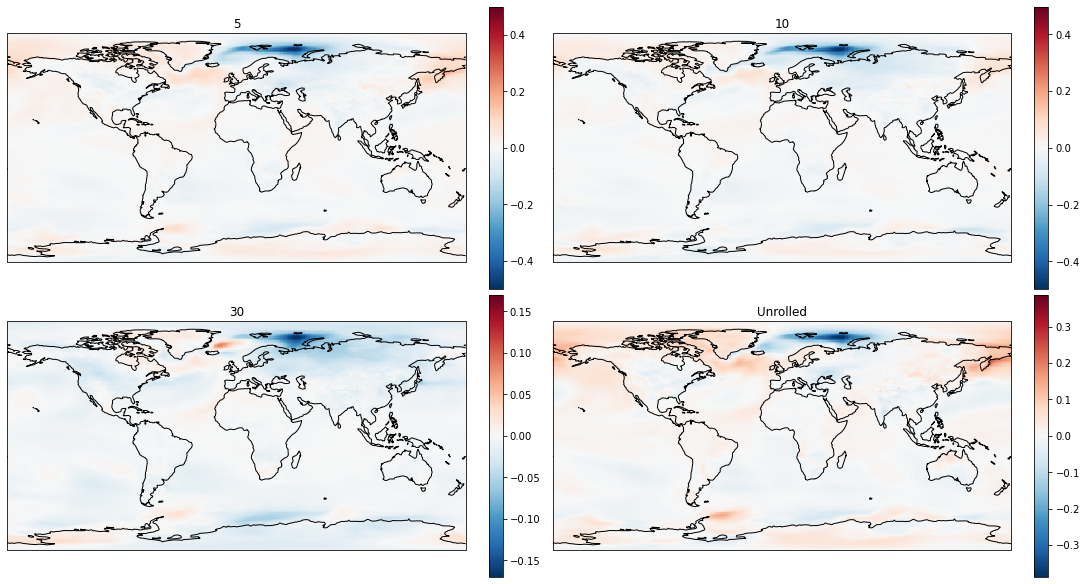

In [21]:
t = 10
dif_t = 5

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
    (conv_1pct_rolling_ds[roll_amt] - conv_climatology_1pct_rolling_ds[roll_amt]).weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                               # vmax = 1.5, vmin = -1.5,
                                                                                                cmap = 'RdBu_r')
    ax.set_title(roll_amt)
    
    ax.coastlines()
#unrolled
(conv_1pct_ds- conv_climatology_1pct_ds).weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax4,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                #vmax = 1.5, vmin = -1.5,
                                                                                                cmap = 'RdBu_r')  
ax4.set_title('Unrolled')

ax4.coastlines()


## Error for the climatology vs. not

In [40]:
rmse_climatology_ds = rmse(conv_climatology_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'))

rmse_ds = rmse(conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'))

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = [15,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

rmse_climatology_ds.plot(ax = ax1,
                     transform = ccrs.PlateCarree(), 
                                 vmin = -5, vmax = 5,
                                 cmap = 'RdBu_r')
ax1.coastlines()
rmse_ds.plot(ax = ax2, 
             transform = ccrs.PlateCarree(), 
             vmin = -5, vmax = 5,
             cmap = 'RdBu_r')
ax2.coastlines()

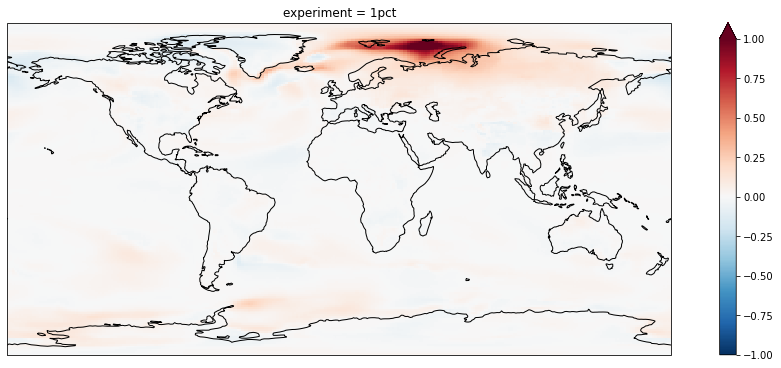

In [43]:
fig, ax1 = plt.subplots(1,1, figsize = [15,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

(rmse_climatology_ds-rmse_ds).plot(ax = ax1,
                     transform = ccrs.PlateCarree(), 
                                 vmin = -1, vmax = 1,
                                 cmap = 'RdBu_r')
ax1.coastlines()

In [44]:
roll_amt = 30

rmse_roll_climatology_ds = rmse(conv_climatology_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'))

rmse_roll_ds = rmse(conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'))

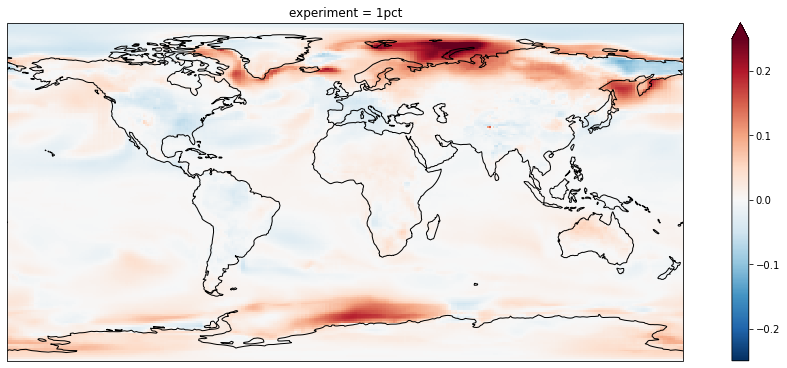

In [46]:
fig, ax1 = plt.subplots(1,1, figsize = [15,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

(rmse_roll_climatology_ds-rmse_roll_ds).plot(ax = ax1,
                     transform = ccrs.PlateCarree(), 
                                 vmin = -.25, vmax = .25,
                                 cmap = 'RdBu_r')
ax1.coastlines()

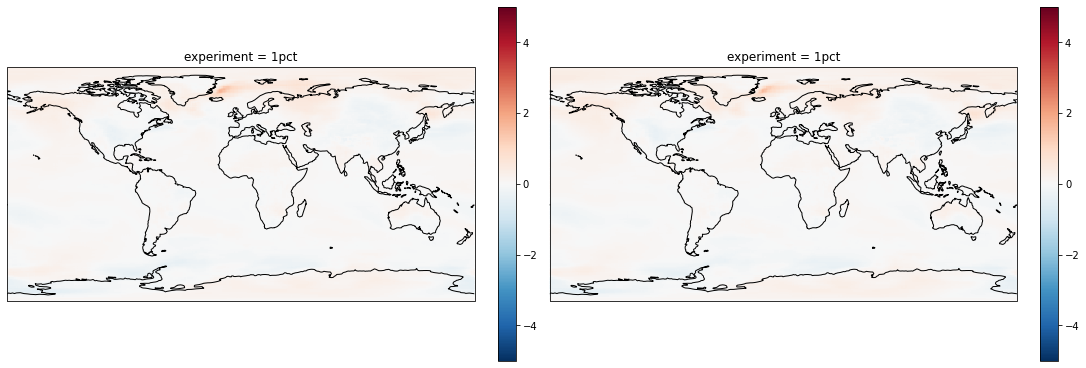

In [36]:
t = 10
dif_t = 5
fig, (ax1,ax2) = plt.subplots(1,2, figsize = [15,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

((conv_climatology_1pct_ds).weighted(model_weights).mean(dim = ['model','pulse_type']) - 
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax1,
                                                                                                                                 transform = ccrs.PlateCarree(), 
                                                                                                                                             vmin = -5, vmax = 5,
                                                                                                                                             cmap = 'RdBu_r')
ax1.coastlines()
((conv_1pct_ds).weighted(model_weights).mean(dim = ['model','pulse_type']) - 
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax2, 
                                                                                                                                             transform = ccrs.PlateCarree(), 
                                                                                                                                             vmin = -5, vmax = 5,
                                                                                                                                             cmap = 'RdBu_r')
ax2.coastlines()

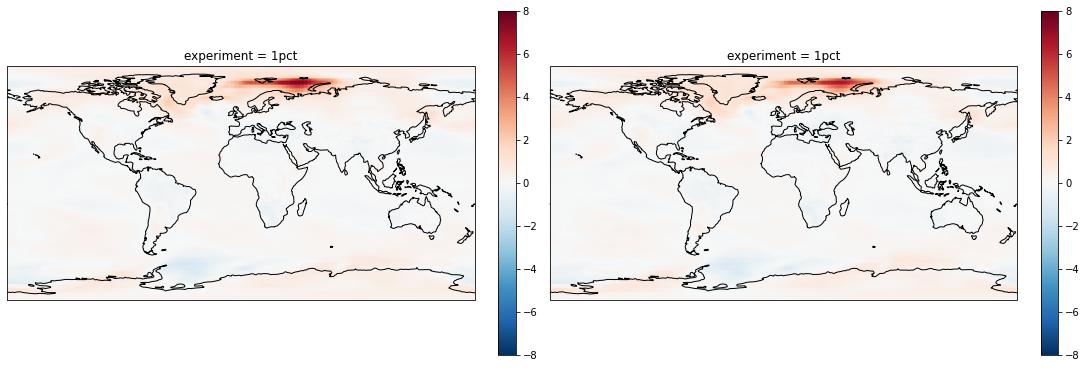

In [37]:
t = 50
dif_t = 5
fig, (ax1,ax2) = plt.subplots(1,2, figsize = [15,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

((conv_climatology_1pct_ds).weighted(model_weights).mean(dim = ['model','pulse_type']) - 
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax1,
                                                                                                                                 transform = ccrs.PlateCarree(), 
                                                                                                                                             vmin = -8, vmax = 8,
                                                                                                                                             cmap = 'RdBu_r')
ax1.coastlines()
((conv_1pct_ds).weighted(model_weights).mean(dim = ['model','pulse_type']) - 
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax2, 
                                                                                                                                             transform = ccrs.PlateCarree(), 
                                                                                                                                             vmin = -8, vmax = 8,
                                                                                                                                             cmap = 'RdBu_r')
ax2.coastlines()

## Plot the rolling means and differences

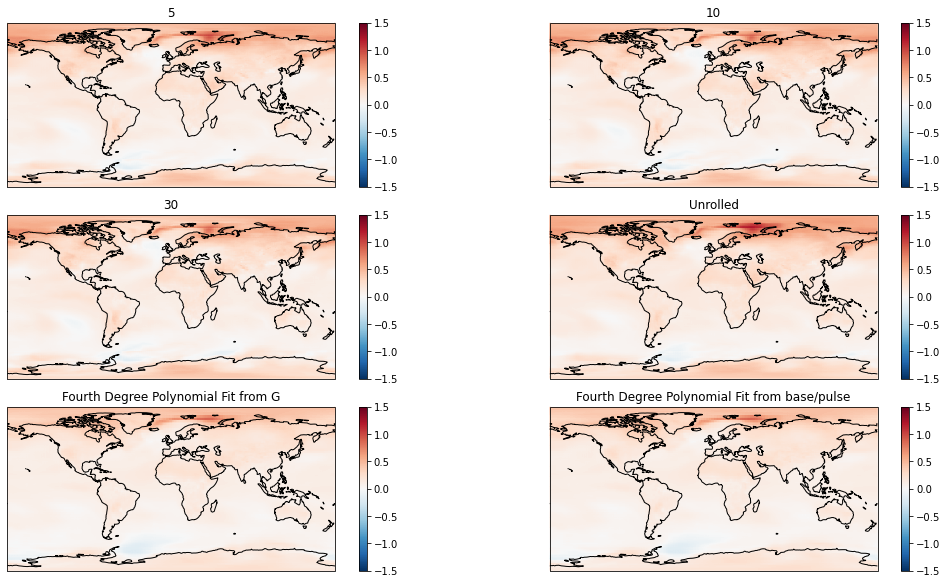

In [69]:
t = 10
dif_t = 5

fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
    conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 1.5, vmin = -1.5,
                                                                                                cmap = 'RdBu_r')
    ax.set_title(roll_amt)
    
    ax.coastlines()
#unrolled
conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax4,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 1.5, vmin = -1.5,
                                                                                                cmap = 'RdBu_r')  
ax4.set_title('Unrolled')

ax4.coastlines()

#rolled
for polyfit, ax in zip(['normal_base_pulse', 'polyfit_base_pulse'], [ax5, ax6]):
    conv_poly_1pct_ds.sel(polyfit = polyfit).weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 1.5, vmin = -1.5,
                                                                                                cmap = 'RdBu_r')


    ax.set_title(p_fit_name_dict[polyfit])
    ax.coastlines()


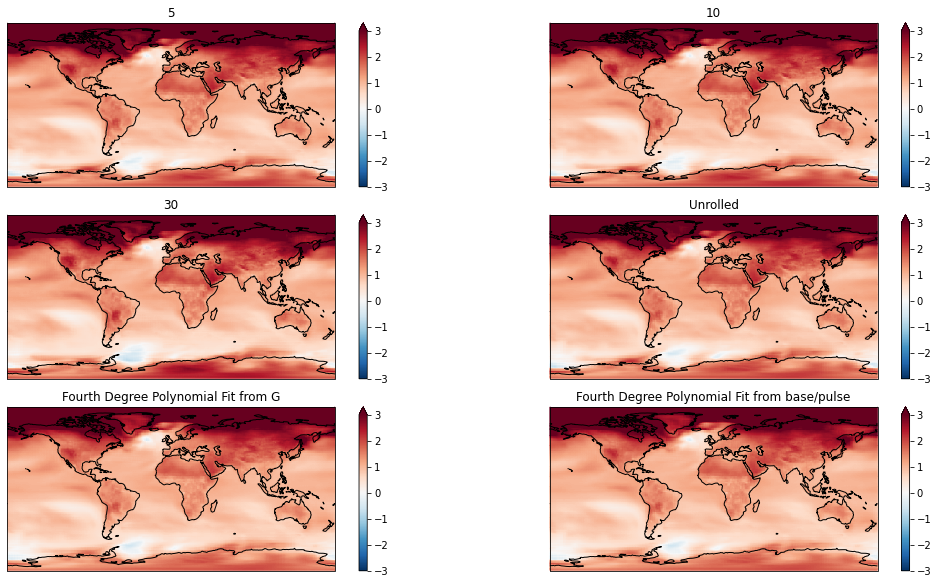

In [68]:
t = 50
dif_t = 5

fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
    conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 3.0, vmin = -3.0,
                                                                                                cmap = 'RdBu_r')
    ax.set_title(roll_amt)
    
    ax.coastlines()
#unrolled
conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax4,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 3.0, vmin = -3.0,
                                                                                                cmap = 'RdBu_r')  
ax4.set_title('Unrolled')

ax4.coastlines()

#rolled
for polyfit, ax in zip(['normal_base_pulse', 'polyfit_base_pulse'], [ax5, ax6]):
    conv_poly_1pct_ds.sel(polyfit = polyfit).weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 3.0, vmin = -3.0,
                                                                                                cmap = 'RdBu_r')


    ax.set_title(p_fit_name_dict[polyfit])
    ax.coastlines()


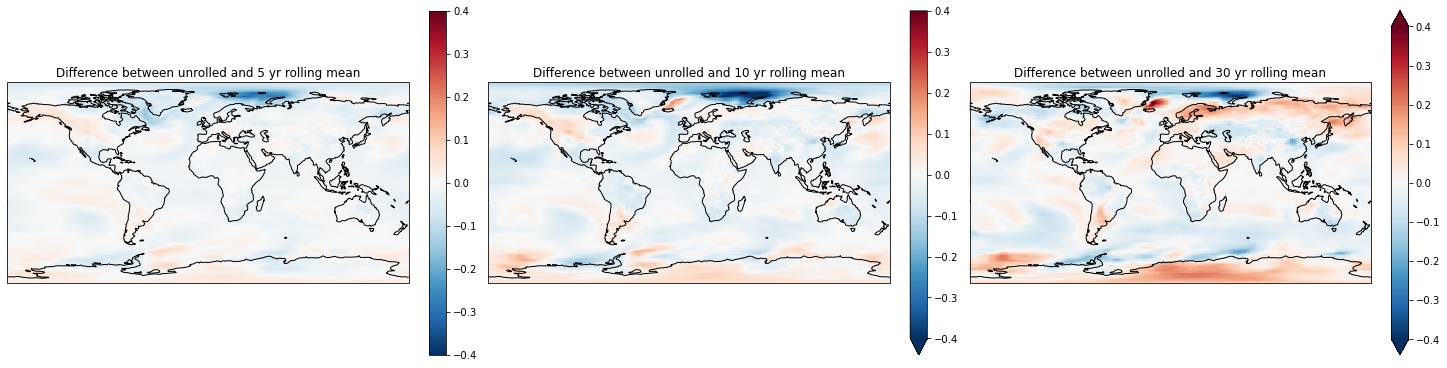

In [41]:
t = 10
dif_t = 5

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's')
#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
    (conv_1pct_ds - conv_1pct_rolling_ds[roll_amt]).weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(), 
                                                                                                  vmin = -0.4, vmax = 0.4, cmap = 'RdBu_r')
    

    ax.set_title(f'Difference between unrolled and {roll_amt} yr rolling mean')
    
    ax.coastlines()


In [57]:
## global mean rmse
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
        
    print(roll_amt, rmse(conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).weighted(A).mean())
    
    
print('no roll', rmse(conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']), 
ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).weighted(A).mean())

5 <xarray.DataArray ()>
array(0.44161236)
Coordinates:
    experiment  <U4 '1pct'
10 <xarray.DataArray ()>
array(0.44391262)
Coordinates:
    experiment  <U4 '1pct'
30 <xarray.DataArray ()>
array(0.47301187)
Coordinates:
    experiment  <U4 '1pct'
no roll <xarray.DataArray ()>
array(0.4449276)
Coordinates:
    experiment  <U4 '1pct'


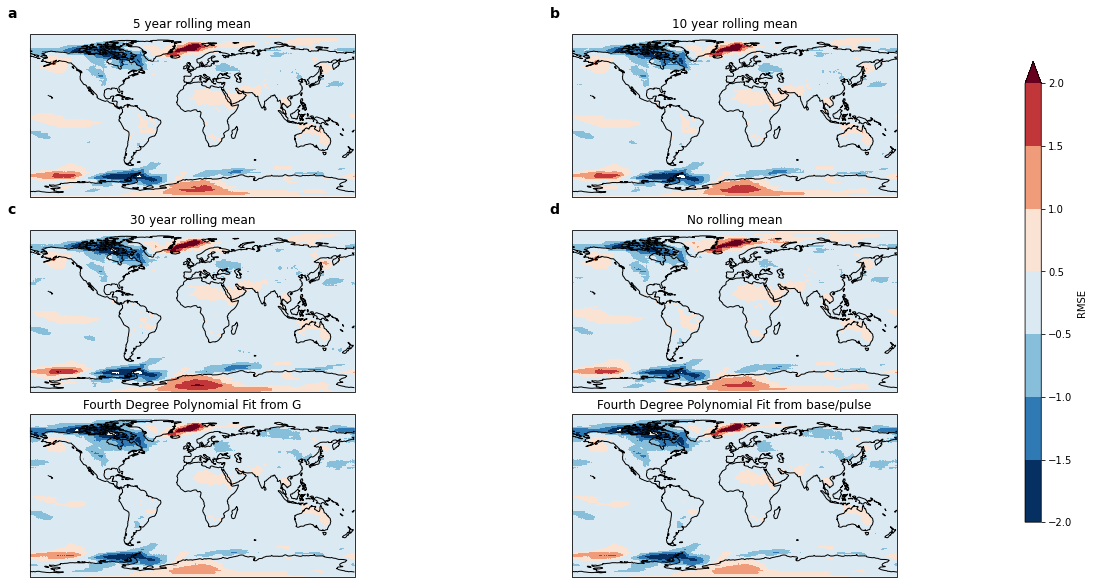

In [96]:
levels = [-2.0,-1.5,-1.0,-0.5,0.5,1,1.5,2.0]
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
t = 30
#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
        
    (conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type']) - 
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = t).plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                levels = levels, extend = 'max', 
                                                                                             add_colorbar = False,
                                                                                                cmap = 'RdBu_r')
    ax.set_title(f'{roll_amt} year rolling mean')
    
    ax.coastlines()
#unrolled
axp = (conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']) - 
ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = t).plot(ax = ax4,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                levels = levels, extend = 'max', add_colorbar = False,
                                                                                                cmap = 'RdBu_r')  


ax4.set_title('No rolling mean')
ax4.coastlines()

#polyfit
p_fit_name_dict = {'normal_base_pulse':'Fourth Degree Polynomial Fit from G', 'polyfit_base_pulse':'Fourth Degree Polynomial Fit from base/pulse'}

for polyfit, ax in zip(['normal_base_pulse', 'polyfit_base_pulse'], [ax5, ax6]):
    axp = (conv_poly_1pct_ds.sel(polyfit = polyfit).weighted(model_weights).mean(dim = ['model','pulse_type']) - 
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = t).plot(ax = ax,  
                                                                                                      transform = ccrs.PlateCarree(),
                                                                                                    levels = levels, extend = 'max', add_colorbar = False,
                                                                                                    cmap = 'RdBu_r')  


    ax.set_title(p_fit_name_dict[polyfit])
    ax.coastlines()




#colorbar

cbaxes = fig.add_axes([1.02,.1,.015,.8])
cb = plt.colorbar(axp, cax = cbaxes)
cb.set_label('RMSE')

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
#plt.savefig('figures/paper/supp_rmse_rolling.png', bbox_inches = 'tight', dpi = 350)

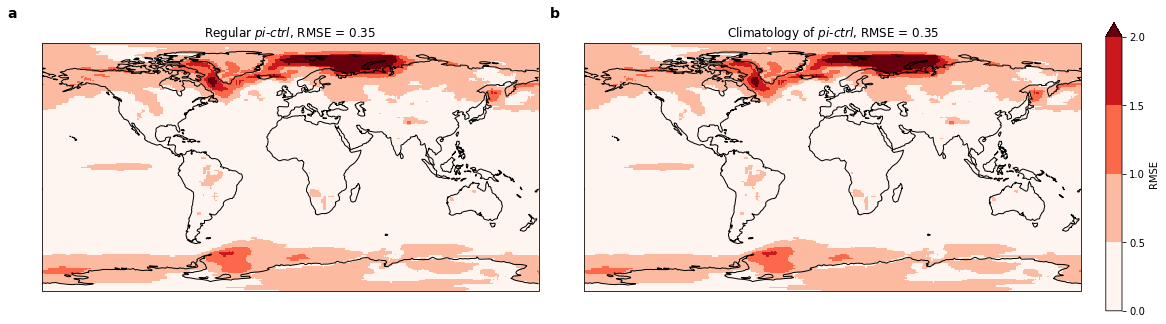

In [134]:
#RMSE comparison to climatology

fig, (ax1,ax2) = plt.subplots(1,2, figsize = [15,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

pfit = 'normal_base_pulse'
rmse(conv_poly_1pct_ds.sel(polyfit = pfit).weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'), 90).plot(ax = ax1,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                levels = levels, extend = 'max', 
                                                                                             add_colorbar = False,
                                                                                                cmap = 'Reds')
amt = rmse(conv_poly_1pct_ds.sel(polyfit = pfit).weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'), 90).weighted(A).mean().values

ax1.coastlines()
ax1.set_title('Regular $\it{pi}$-$\it{ctrl}$' + f', RMSE = {np.round(amt,2)}')

pfit = 'climatology_polyfit'
axp = rmse(conv_poly_1pct_ds.sel(polyfit = pfit).weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'), 90).plot(ax = ax2,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                levels = levels, extend = 'max', 
                                                                                             add_colorbar = False,
                                                                                                cmap = 'Reds')
amt = rmse(conv_poly_1pct_ds.sel(polyfit = pfit).weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'), 90).weighted(A).mean().values

ax2.coastlines()
ax2.set_title('Climatology of $\it{pi}$-$\it{ctrl}$' + f', RMSE = {np.round(amt,2)}')
#colorbar

cbaxes = fig.add_axes([1.02,.1,.015,.8])
cb = plt.colorbar(axp, cax = cbaxes)
cb.set_label('RMSE')

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
plt.savefig('figures/paper/supp_rmse_climatology_comp.png', bbox_inches = 'tight', dpi = 350)

In [136]:
for pfit in ['climatology_polyfit', 'normal_base_pulse']:
    print(pfit, rmse(conv_poly_1pct_ds.sel(polyfit = pfit).weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'), 90).max().values)

climatology_polyfit 8.061945950259842
normal_base_pulse 8.061945950259842


In [137]:
for pfit in ['climatology_polyfit', 'normal_base_pulse']:
    print(pfit, rmse(conv_poly_1pct_ds.sel(polyfit = pfit).weighted(model_weights).mean(dim = ['model','pulse_type']),
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model'), 90).min().values)

climatology_polyfit 0.07695107342019104
normal_base_pulse 0.07695107342019104


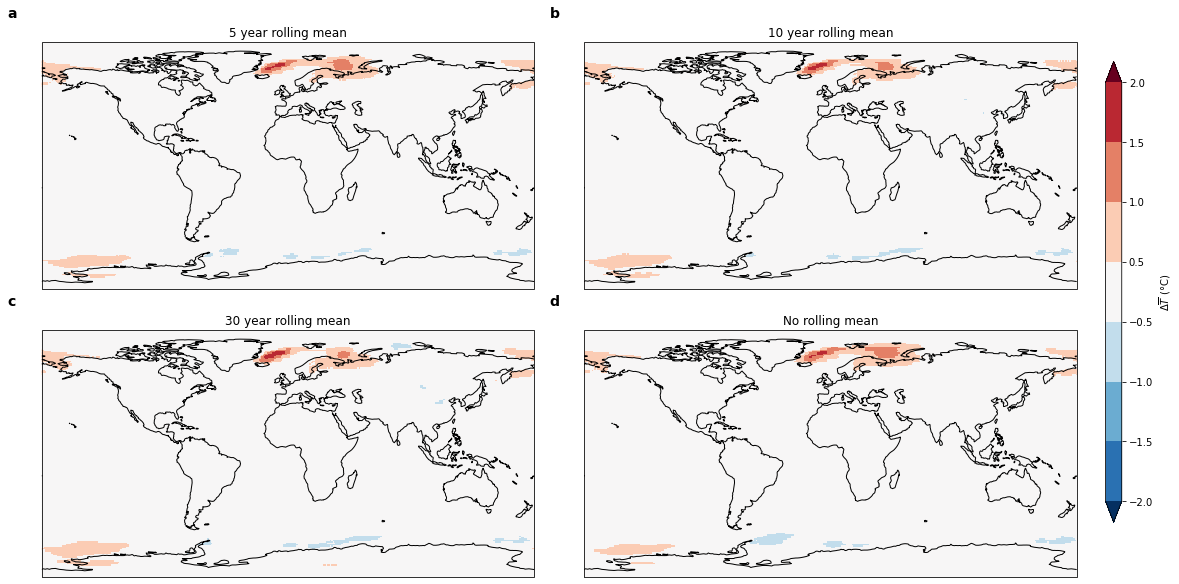

In [66]:
t = 20
dif_t = 5

levels = [-2,-1.5,-1,-0.5,0.5,1,1.5,2.0]
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
        
    (conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type'])-
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                levels = levels, extend = 'both', 
                                                                                             add_colorbar = False,
                                                                                                cmap = 'RdBu_r')
    ax.set_title(f'{roll_amt} year rolling mean')
    
    ax.coastlines()
#unrolled
axp = (conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']) - 
ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax4,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                levels = levels, extend = 'both', add_colorbar = False,
                                                                                                cmap = 'RdBu_r')  


ax4.set_title('No rolling mean')
ax4.coastlines()

#colorbar

cbaxes = fig.add_axes([1.02,.1,.015,.8])
cb = plt.colorbar(axp, cax = cbaxes)
cb.set_label('$\Delta \overline{T}$ ($\degree$C)')

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
plt.savefig(f'figures/talks/supp_rolling_comparison_{t}.png', bbox_inches = 'tight', dpi = 350)

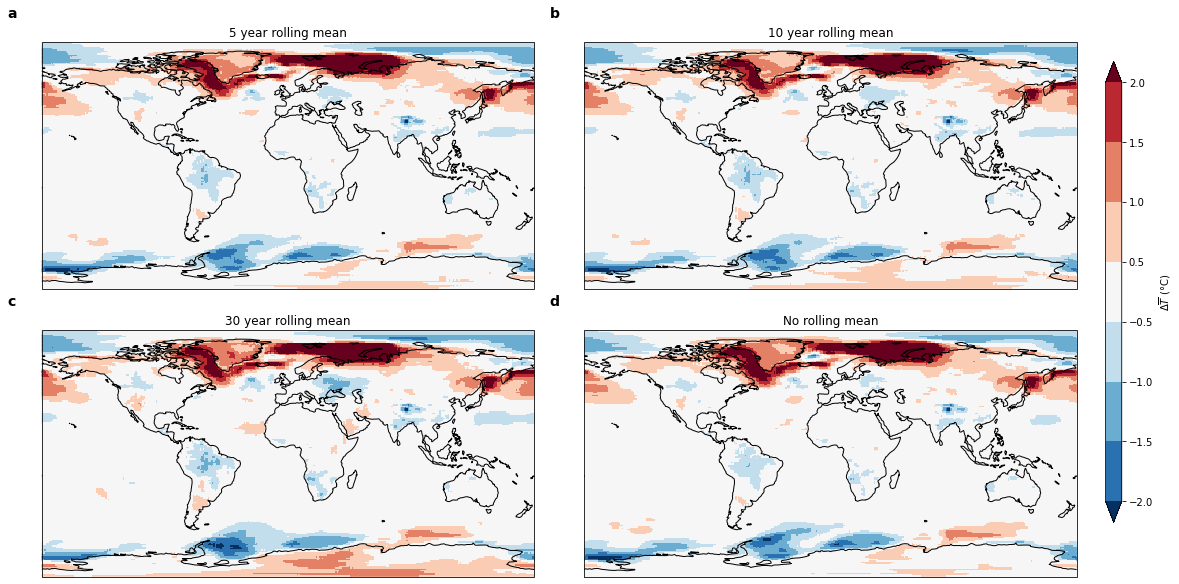

In [50]:
t = 80
dif_t = 5

levels = [-2,-1.5,-1,-0.5,0.5,1,1.5,2.0]
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
        
    (conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type'])-
    ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                levels = levels, extend = 'both', 
                                                                                             add_colorbar = False,
                                                                                                cmap = 'RdBu_r')
    ax.set_title(f'{roll_amt} year rolling mean')
    
    ax.coastlines()
#unrolled
axp = (conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']) - 
ds_dif['tas'].sel(experiment = '1pct').weighted(onepct_model_weights).mean('model')).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax4,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                levels = levels, extend = 'both', add_colorbar = False,
                                                                                                cmap = 'RdBu_r')  


ax4.set_title('No rolling mean')
ax4.coastlines()

#colorbar

cbaxes = fig.add_axes([1.02,.1,.015,.8])
cb = plt.colorbar(axp, cax = cbaxes)
cb.set_label('$\Delta \overline{T}$ ($\degree$C)')

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
plt.savefig(f'figures/talks/supp_rolling_comparison_{t}.png', bbox_inches = 'tight', dpi = 350)